In [2]:
from UTILITY_quickstart import *
?initializeTao

ModuleNotFoundError: No module named 'UTILITY_quickstart'

In [125]:
tao = initializeTao(
    inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly_2023-05-16InjectorMatch.h5',
    #inputBeamFilePathSuffix = '/beams/L0AFEND_facet2-lattice.h5',

    #runImpactTF=True,
    #impactGridCount=8,
    #numMacroParticles=1e4,
    loadDefaultLatticeTF=False,
    lastTrackedElement = "end"
)

trackBeam(tao)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Base Tao lattice
Number of macro particles defined by input file


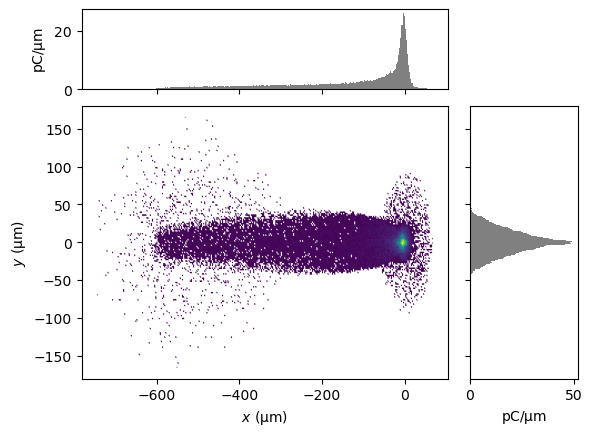

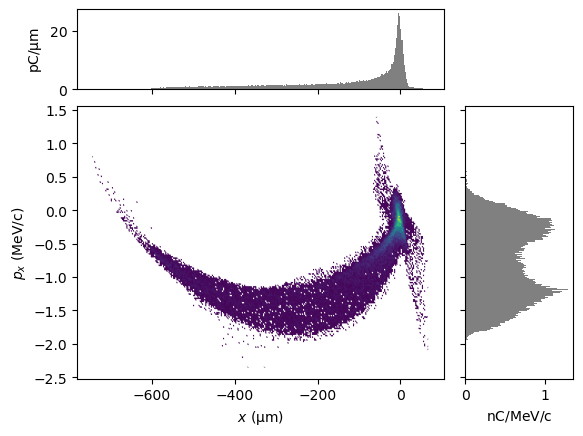

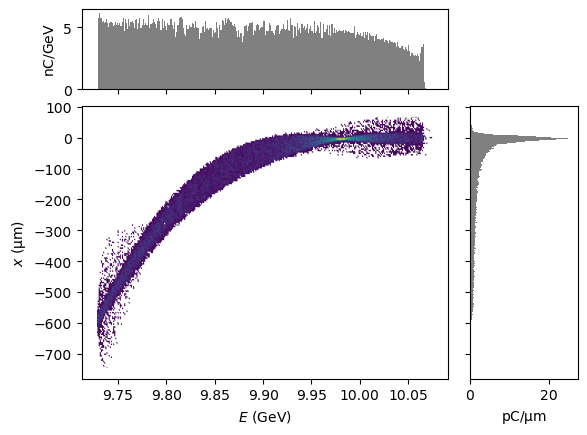

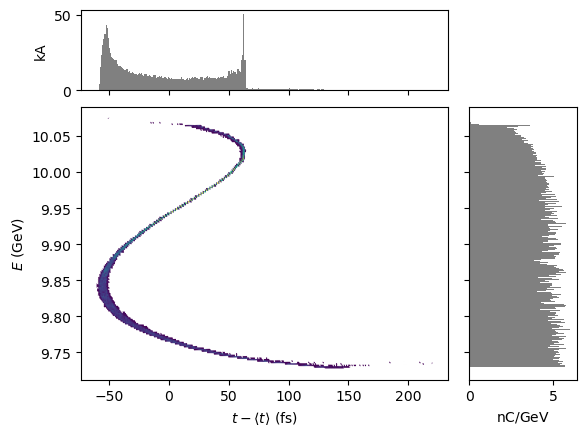

ParticleGroup with 76267 particles with total charge 1.6018414376841436e-09 C


In [126]:
P = getBeamAtElement(tao, "PENT")
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'px',  bins=300))
display(plotMod(P, 'energy', 'x',  bins=300))
display(plotMod(P, 'delta_t', 'energy',  bins=300))
plt.clf()
print(P)

In [127]:
P["sigma_x"]

0.00017180287961885164

Sum counts: 76027


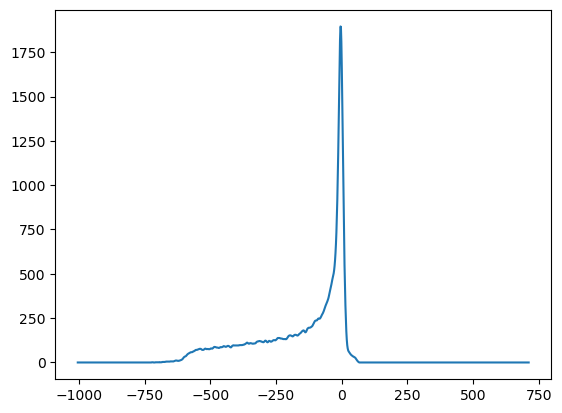

In [128]:
xData = P.x
#xData = xData - np.mean(xData)

from scipy.ndimage import gaussian_filter1d
def histogramDataUnified(data):
    
    
    counts, bin_edges = np.histogram(data, 
                                     range=(
                                         np.mean(data) - 5*np.std(data),
                                         np.mean(data) + 5*np.std(data)
                                     ), 
                                     #bins = int(len(data)/100)
                                     bins = 1000
                                    )

    #Optional: Gaussian blur
    counts = gaussian_filter1d(counts, 2.0)
    
    return counts, bin_edges

# Generate histogram data
counts, bin_edges = histogramDataUnified(xData)

# Print histogram data
# print("Counts:", counts)
# print("Bin edges:", bin_edges)

print(f"Sum counts: {np.sum(counts)}")


# Plotting the histogram
plt.plot(1e6*(bin_edges[:-1]),counts)
plt.show()

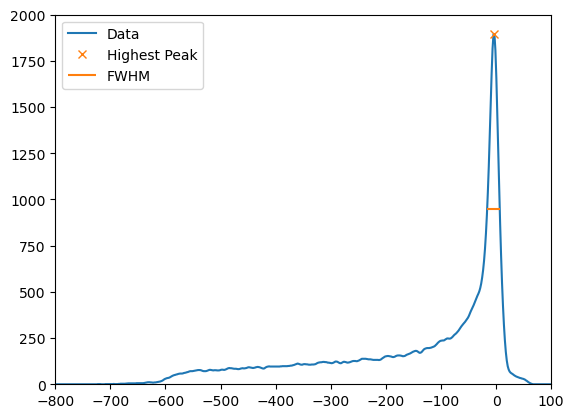

In [129]:
from scipy.signal import find_peaks, peak_widths

# Create some example data
x = 1e6*(bin_edges[:-1])
y = counts

# Find the peaks in the data
peaks, properties = find_peaks(y)

# Identify the highest peak
highest_peak = peaks[np.argmax(y[peaks])]

# Calculate the FWHM using peak_widths for the highest peak
results_half = peak_widths(y, [highest_peak], rel_height=0.5)

# Interpolate to find more accurate x positions for the half-maximum points
x_min = np.interp(results_half[2], np.arange(len(x)), x)
x_max = np.interp(results_half[3], np.arange(len(x)), x)

# Plot the data, the highest peak, and the FWHM
plt.plot(x, y, label='Data')
plt.plot(x[highest_peak], y[highest_peak], 'x', label='Highest Peak')
plt.hlines(results_half[1], x_min, x_max, color='C1', label='FWHM')
plt.legend()
#plt.xlabel('X-axis')
#plt.ylabel('Y-axis')
#plt.title('Gaussian Peak with FWHM')
plt.xlim([-800, 100])
plt.ylim([0, 2000])

plt.show()


In [130]:
fwhm = (x_max-x_min)[0]
impliedRMS = fwhm / 2.355
print(f"""Actual RMS = \t\t\t{1e6*P["sigma_x"]}""")
print(f"FWHM = \t\t\t\t{fwhm} \nImplied (Gaussian) RMS = \t{impliedRMS}")

Actual RMS = 			171.80287961885165
FWHM = 				22.879577832712243 
Implied (Gaussian) RMS = 	9.71531967418779


In [131]:
np.sum(counts)

76027

In [132]:
results_half

(array([13.31734246]),
 array([947.5]),
 array([575.26859504]),
 array([588.5859375]))

In [133]:
#Triangle approximation


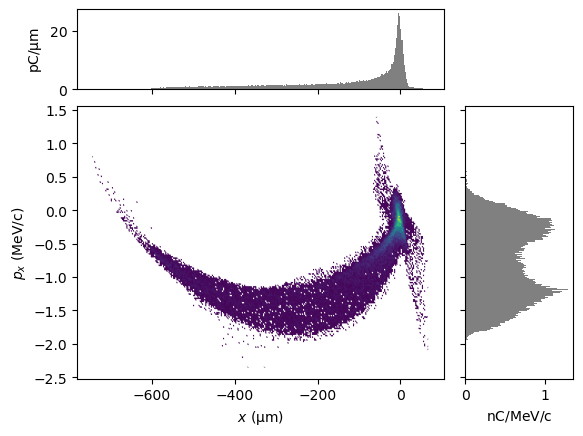

In [134]:
display(plotMod(P, 'x', 'px',  bins=300))

Sum counts: 75427839


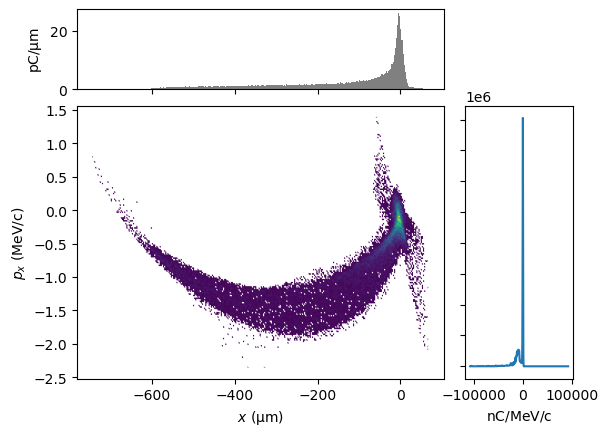

In [135]:
#Optional: transform
xData = np.array([x - 1e-4*y for [x, px] in np.column_stack((P.x, P.px))])


# Generate histogram data
counts, bin_edges = histogramDataUnified(xData)

# Print histogram data
# print("Counts:", counts)
# print("Bin edges:", bin_edges)

print(f"Sum counts: {np.sum(counts)}")


# Plotting the histogram
plt.plot(1e6*(bin_edges[:-1]),counts)
plt.show()

# Artificial emittance scan

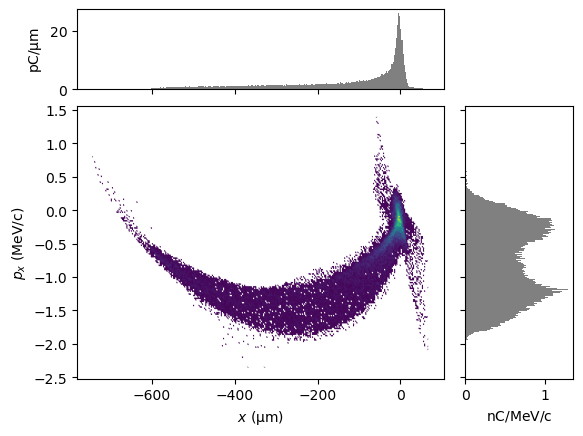

In [136]:
display(plotMod(P, 'x', 'px',  bins=300))

In [137]:
import copy
PMod = copy.deepcopy(P)

In [138]:
PMod.x = P.x + 10*(P.px / P.pz)

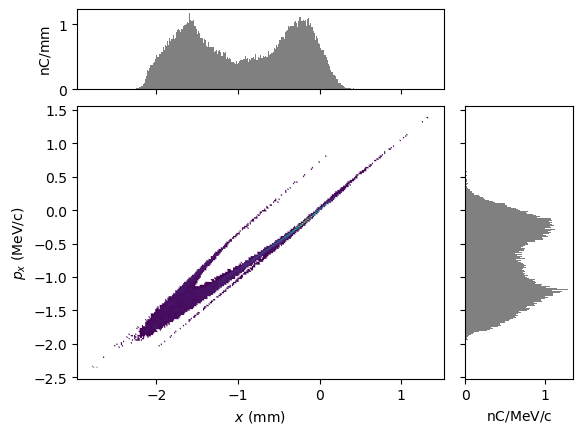

In [139]:
display(plotMod(PMod, 'x', 'px',  bins=300))

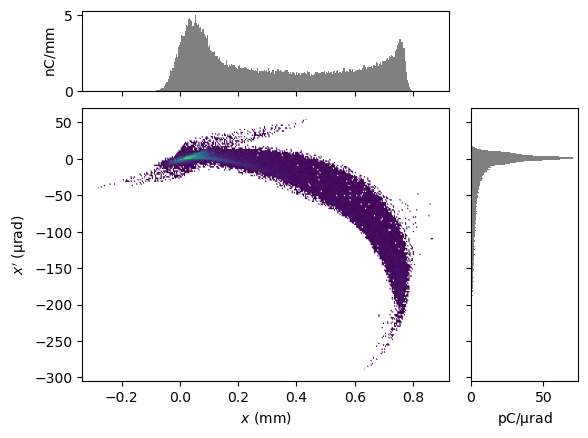

True sigma_x, sigma_xp, rho: 0.0002658045907145158, 5.183013708376487e-05, -0.8424159461369393
Optimizer parameters: sigma_x = 0.00026580459071451573, sigma_xp = 5.183013708376486e-05, rho = -0.8424049005215866


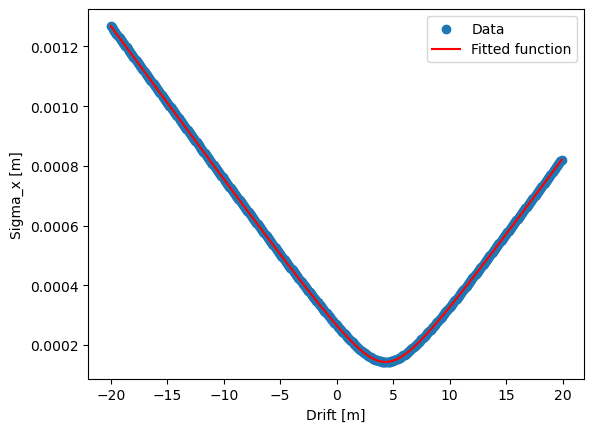

Actual emittance: 	 0.0001414246569172006
Fit emittance: 		 0.00014363439614283014


In [140]:
P = getBeamAtElement(tao, "MFFF")
display(plotMod(P, 'x', 'xp',  bins=300))
plt.clf()

zValues = np.arange(-20, 20, 0.1)
sigmaXResults = [ np.std(P.x + z * P.xp) for z in zValues]


from scipy.optimize import curve_fit

def model_function(z, sigmax, sigmaxp, rho):
    return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)

# Fit the model to the data
popt, pcov = curve_fit(model_function, zValues, sigmaXResults, p0=[1, 1, 0])

# Extract optimal parameters
sigmax_opt, sigmaxp_opt, rho_opt = popt

print(f"""True sigma_x, sigma_xp, rho: {P.std("x")}, {P.std("xp")}, {P["cov_x__xp"] / (P.std("x") * P.std("xp"))}""")
print(f"Optimizer parameters: sigma_x = {sigmax_opt}, sigma_xp = {sigmaxp_opt}, rho = {rho_opt}")


# Plot the data and the fit
plt.scatter(zValues, sigmaXResults, label='Data')
plt.plot(zValues, model_function(zValues, *popt), label='Fitted function', color='red')
plt.xlabel('Drift [m]')
plt.ylabel('Sigma_x [m]')
plt.legend()
plt.show()

emit_opt = np.sqrt( sigmax_opt**2 * sigmaxp_opt**2 - (rho_opt * sigmax_opt * sigmaxp_opt)**2 )
print(f"""Actual emittance: \t {P["norm_emit_x"]}""")
print(f"""Fit emittance: \t\t {emit_opt * P["mean_gamma"]}""")

## Use smallest interval implied sigma

In [141]:
def smallest_interval(nums, percentage=0.9):
    nums.sort()
    n = len(nums)
    k = int(n * percentage)
    min_range = float('inf')
    interval = (None, None)
    
    for i in range(n - k + 1):
        current_range = nums[i + k - 1] - nums[i]
        if current_range < min_range:
            min_range = current_range
            interval = (nums[i], nums[i + k - 1])
    
    return interval[1]-interval[0]

# Example usage:
numbers = P.x
fractionContained = 0.5
interval = smallest_interval(numbers, percentage = fractionContained)
print(f"The smallest interval containing at least {100*fractionContained}% of the numbers = {interval}")
#print("Length = ", interval[1]-interval[0])

The smallest interval containing at least 50.0% of the numbers = 0.00031359770998521524


In [142]:
fractionsToCheck = np.arange(0.05, 1, 0.05)
intervalLengths = [ smallest_interval(numbers, percentage = fractionContained) for fractionContained in fractionsToCheck ]

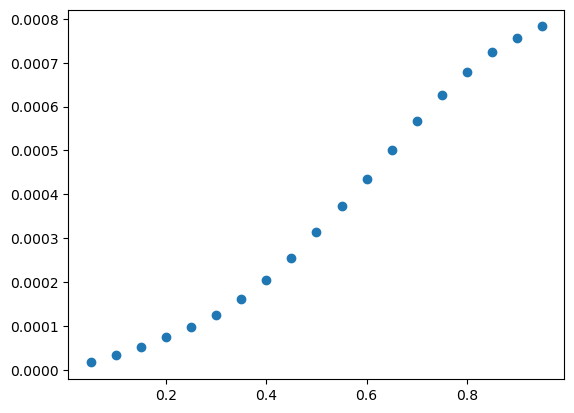

In [143]:
plt.clf()
plt.plot(fractionsToCheck, intervalLengths, "o")
plt.show()

In [144]:
import scipy

scipy.special.erf(1 / np.sqrt(2))

0.6826894921370859

In [145]:
def smallestIntervalImpliedSigma(nums, percentage=0.9):
    interval = smallest_interval(nums, percentage)
    intervalToSigmaFactor = scipy.special.erfinv(percentage) * (2 * np.sqrt(2))
    return interval/intervalToSigmaFactor

testData = np.random.normal(0, 1, 10000)

print(f"Actual rms: {np.std(testData)}")
percentagesToCheck = [0.1, 0.5, 0.68, 0.9, 0.95, 0.99]
[print(f"Estimate for {100*i}% = {smallestIntervalImpliedSigma(testData, i)}") for i in percentagesToCheck]

testData = np.random.normal(1.2, 2.7, 10000)

print(f"Actual rms: {np.std(testData)}")
percentagesToCheck = [0.1, 0.5, 0.68, 0.9, 0.95, 0.99]
[print(f"Estimate for {100*i}% = {smallestIntervalImpliedSigma(testData, i)}") for i in percentagesToCheck]

Actual rms: 0.9882885773813432
Estimate for 10.0% = 0.9310421487381302
Estimate for 50.0% = 0.9906199407539968
Estimate for 68.0% = 0.9874866853989224
Estimate for 90.0% = 0.9868820070831923
Estimate for 95.0% = 0.9758496015996837
Estimate for 99.0% = 0.9897453616000765
Actual rms: 2.7003526147523558
Estimate for 10.0% = 2.576784453249174
Estimate for 50.0% = 2.664171938116249
Estimate for 68.0% = 2.686285097106342
Estimate for 90.0% = 2.691793857708944
Estimate for 95.0% = 2.694179075658375
Estimate for 99.0% = 2.7335701700078663


[None, None, None, None, None, None]

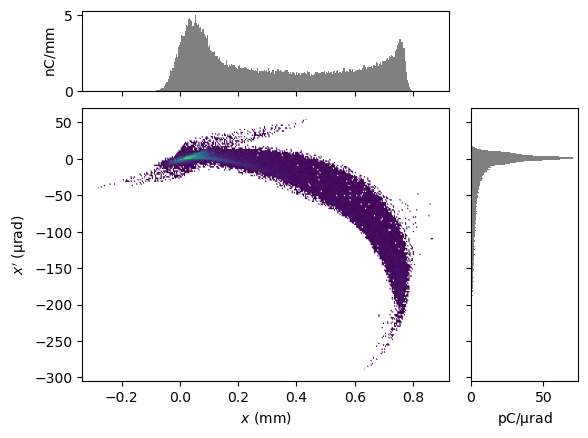

True sigma_x, sigma_xp, rho: 0.0002658045907145158, 5.183013708376487e-05, -0.8424159461369393
Optimizer parameters: sigma_x = 0.0002450175537309808, sigma_xp = 2.6533375931710564e-05, rho = -0.7461570437495936


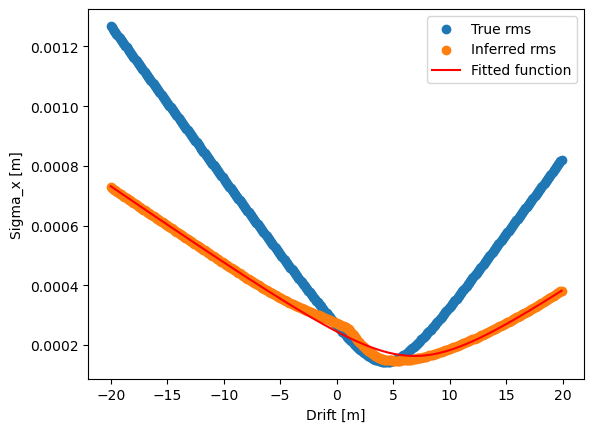

Actual emittance: 	 0.0001414246569172006
Fit emittance: 		 8.374591692228734e-05


In [146]:
P = getBeamAtElement(tao, "MFFF")
display(plotMod(P, 'x', 'xp',  bins=300))
plt.clf()

zValues = np.arange(-20, 20, 0.1)
sigmaXResults = [ smallestIntervalImpliedSigma(P.x + z * P.xp, percentage = 0.7) for z in zValues]
sigmaXResultsExact = [ np.std(P.x + z * P.xp) for z in zValues]

from scipy.optimize import curve_fit

def model_function(z, sigmax, sigmaxp, rho):
    return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)

# Fit the model to the data
popt, pcov = curve_fit(model_function, zValues, sigmaXResults, p0=[1, 1, 0])

# Extract optimal parameters
sigmax_opt, sigmaxp_opt, rho_opt = popt

print(f"""True sigma_x, sigma_xp, rho: {P.std("x")}, {P.std("xp")}, {P["cov_x__xp"] / (P.std("x") * P.std("xp"))}""")
print(f"Optimizer parameters: sigma_x = {sigmax_opt}, sigma_xp = {sigmaxp_opt}, rho = {rho_opt}")


# Plot the data and the fit
plt.scatter(zValues, sigmaXResultsExact, label='True rms')
plt.scatter(zValues, sigmaXResults, label='Inferred rms')
plt.plot(zValues, model_function(zValues, *popt), label='Fitted function', color='red')
plt.xlabel('Drift [m]')
plt.ylabel('Sigma_x [m]')
plt.legend()
plt.show()

emit_opt = np.sqrt( sigmax_opt**2 * sigmaxp_opt**2 - (rho_opt * sigmax_opt * sigmaxp_opt)**2 )
print(f"""Actual emittance: \t {P["norm_emit_x"]}""")
print(f"""Fit emittance: \t\t {emit_opt * P["mean_gamma"]}""")

In [147]:
P = getBeamAtElement(tao, "PENT")
P["sigma_x"]

0.00017180287961885164

In [148]:
smallestIntervalImpliedSigma(P.x, percentage = 0.1)

2.514853934112649e-05

In [149]:
smallestIntervalImpliedSigma(P.x, percentage = 0.7)

0.00011337758271161448

In [150]:
smallestIntervalImpliedSigma(P.x, percentage = 0.99)

0.00012463790099921798

In [151]:
smallest_interval(P.x, percentage=0.1)

6.320398650087542e-06

In [152]:
smallest_interval(P.x, percentage=0.7)

0.00023501662468482215

In [153]:
smallest_interval(P.x, percentage=0.9)

0.00047109041273651447